<a href="https://colab.research.google.com/github/Sohankumar6/Final_Project_MRI/blob/main/cnn_vgg16_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

# Importing libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Creating a base directory and defining the path
base_directory_path = '/content/drive/MyDrive/Final project'
testing_path = base_directory_path + '/Testing'
training_path = base_directory_path + '/Training'

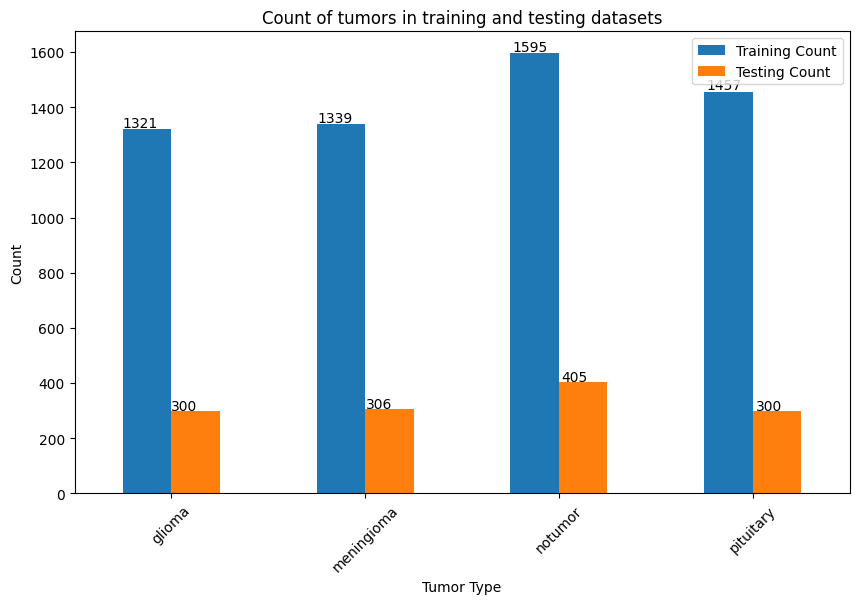

In [3]:
def get_images(directory_path):
    count_image_dict = {}
    img_paths = []
    img_labels = []
    for class_img_dir in os.listdir(directory_path):
        class_img_path = os.path.join(directory_path, class_img_dir)
        if os.path.isdir(class_img_path):
            count_image_dict[class_img_dir] = len(os.listdir(class_img_path))
            for img_name in os.listdir(class_img_path):
                img_paths.append(os.path.join(class_img_path, img_name))
                img_labels.append(class_img_dir)
    return count_image_dict, img_paths, img_labels

training_count, training_img_paths, training_label = get_images(training_path)
testing_count, testing_image_paths, testing_label = get_images(testing_path)

training_data_df = pd.DataFrame(list(training_count.items()), columns=['Tumor Type', 'Training Count'])
testing_data_df = pd.DataFrame(list(testing_count.items()), columns=['Tumor Type', 'Testing Count'])

combined_data_df = pd.merge(training_data_df, testing_data_df, on='Tumor Type')
combined_data_df.set_index('Tumor Type', inplace=True)

axes = combined_data_df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of tumors in training and testing datasets')
plt.xlabel('Tumor Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for p in axes.patches:
    axes.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [4]:
unique_names = list(set(training_label))
class_naming = {label: idx for idx, label in enumerate(unique_names)}

training_label_indx = [class_naming[label] for label in training_label]
testing_label_indx = [class_naming[label] for label in testing_label]

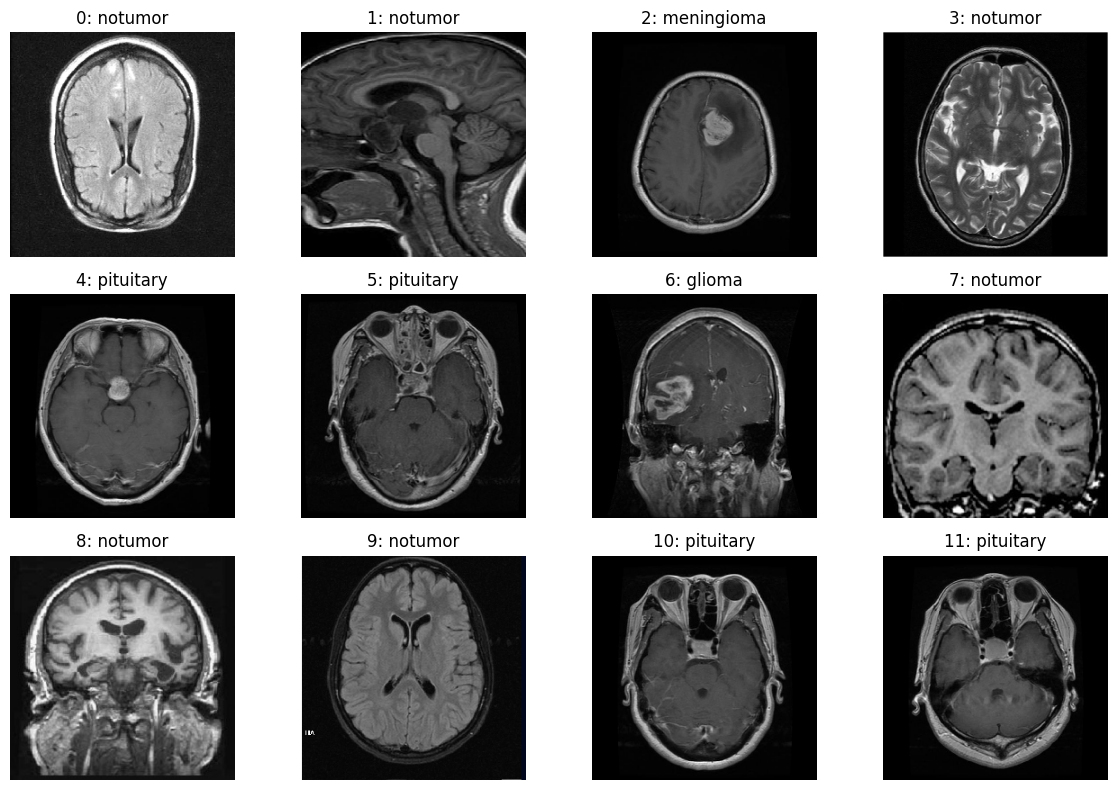

In [5]:
unique_names = list(set(training_label))
class_naming = {label: idx for idx, label in enumerate(unique_names)}

training_label_indx = [class_naming[label] for label in training_label]
testing_label_indx = [class_naming[label] for label in testing_label]

def show_img(path, label_indx, class_naming, index_list=range(10), img_size=250, figsize=(12, 8)):
    num_img = len(index_list)
    rows = (num_img + 3) // 4
    indx_to_class = {v: k for k, v in class_naming.items()}
    _, axes = plt.subplots(nrows=rows, ncols=4, figsize=figsize)
    axes = axes.flatten()

    for i, index in enumerate(index_list):
        if i >= num_img or index >= len(path):
            axes[i].axis('off')
            continue
        image = load_img(path[index], target_size=(img_size, img_size))
        axes[i].imshow(image)
        class_name = indx_to_class[label_indx[index]]
        axes[i].set_title(f'{index}: {class_name}')
        axes[i].axis('off')

    for j in range(num_img, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

combined = list(zip(training_img_paths, training_label_indx))
random.shuffle(combined)
training_img_paths, training_label_indx = zip(*combined)
show_img(training_img_paths, training_label_indx, class_naming, index_list=range(12))

In [6]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

image_dim = (250, 250)
batch_size = 32

In [7]:
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_dim)
    return image, label

def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

def preprocess_test(image, label):
    return image / 255.0, label

training_img_paths = np.array(training_img_paths)
training_label_indx = np.array(training_label_indx)
testing_img_paths = np.array(testing_image_paths)
testing_label_indx = np.array(testing_label_indx)

train_ds = tf.data.Dataset.from_tensor_slices((training_img_paths, training_label_indx))
train_ds = train_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((testing_img_paths, testing_label_indx))
test_ds = test_ds.map(lambda x, y: load_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_preprocessed = train_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

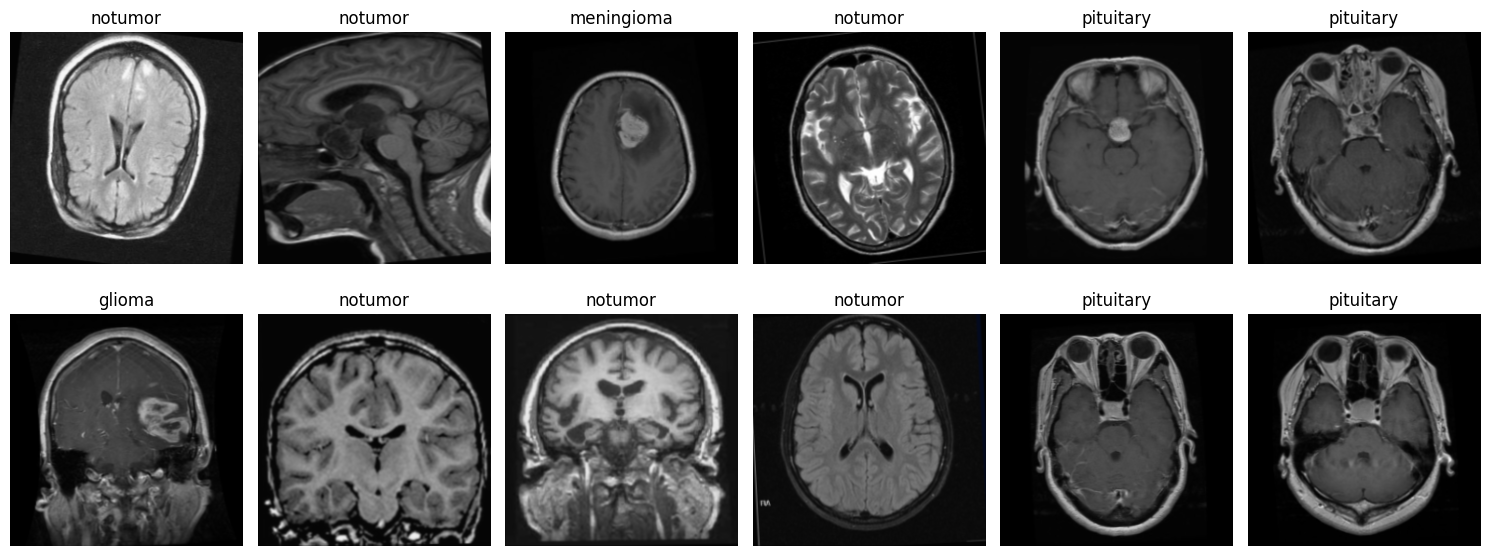

In [8]:
def plot_augmented_images(dataset, shape, class_naming, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    indx_to_class = {v: k for k, v in class_naming.items()}
    for images, label in dataset.take(1):
        for i in range(shape[0] * shape[1]):
            axes = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze())
            plt.title(indx_to_class[label.numpy()[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_naming=class_naming)

In [9]:
num_classes = len(class_naming.keys())
image_shape = (image_dim[0], image_dim[1], 3)
epochs = 50

inv_class_naming = {v: k for k, v in class_naming.items()}
print(f'Inverse class mappings: {inv_class_naming}')

print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
# print(f'Batch size: {batch_size}')


Inverse class mappings: {0: 'pituitary', 1: 'notumor', 2: 'meningioma', 3: 'glioma'}
Number of Classes: 4
Image shape: (250, 250, 3)
Epochs: 50


In [10]:
def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (5, 5), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (4, 4), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

input_shape = (image_dim[0], image_dim[1], 3)
model = create_model(input_shape, num_classes)
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

In [13]:
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

In [14]:
# Train the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)

# Load the best model
model = load_model('model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_accuracy*100:.4f}%")

Epoch 1/50
179/179 [==============================] - 591s 3s/step - loss: 0.7535 - accuracy: 0.6975 - val_loss: 0.6407 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 2/50
179/179 [==============================] - 30s 165ms/step - loss: 0.4388 - accuracy: 0.8281 - val_loss: 0.4329 - val_accuracy: 0.8207 - lr: 0.0010
Epoch 3/50
179/179 [==============================] - 30s 164ms/step - loss: 0.3220 - accuracy: 0.8796 - val_loss: 0.3940 - val_accuracy: 0.8535 - lr: 0.0010
Epoch 4/50
179/179 [==============================] - 30s 165ms/step - loss: 0.2416 - accuracy: 0.9090 - val_loss: 0.2287 - val_accuracy: 0.9268 - lr: 0.0010
Epoch 5/50
179/179 [==============================] - 30s 161ms/step - loss: 0.1828 - accuracy: 0.9329 - val_loss: 0.1643 - val_accuracy: 0.9497 - lr: 0.0010
Epoch 6/50
179/179 [==============================] - 30s 161ms/step - loss: 0.1367 - accuracy: 0.9480 - val_loss: 0.1410 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 7/50
179/179 [==============================] - 

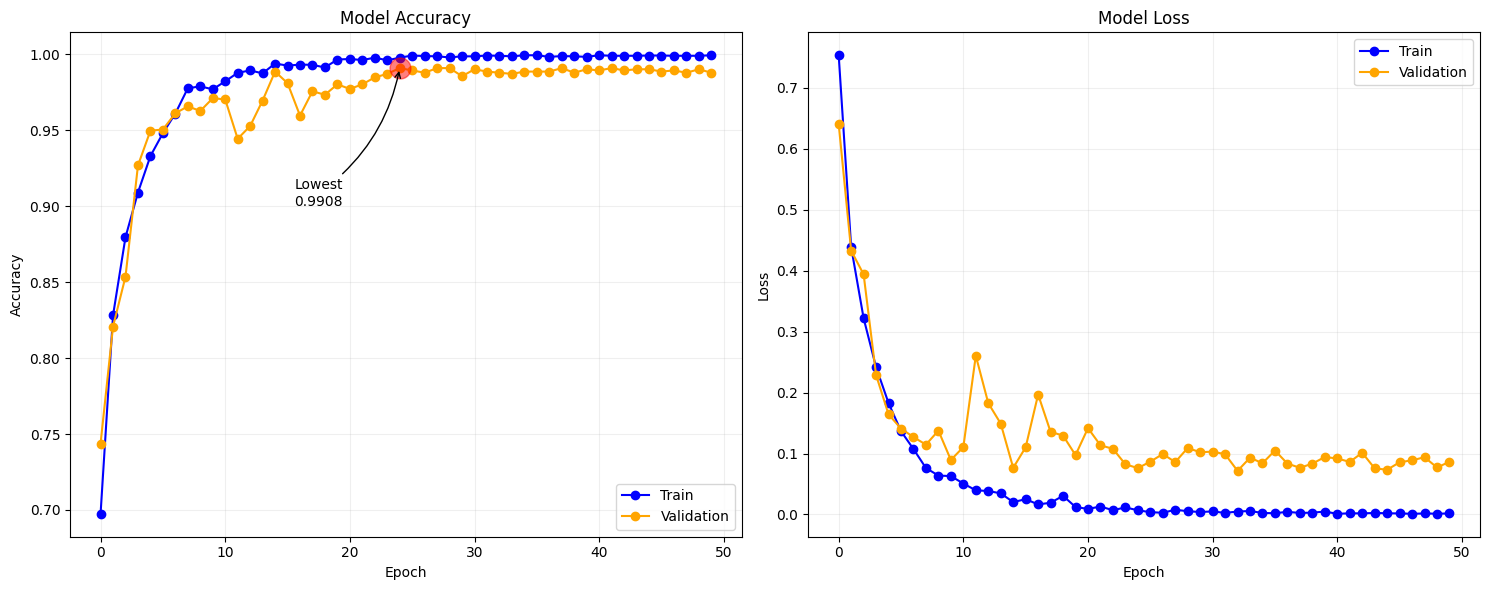

In [15]:
_, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
axes[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
axes[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='lower right')
axes[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
axes[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
axes[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
axes[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
axes[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [16]:
# Using test data for true and preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Get model prediction (Predict expects batch dimension)
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [17]:
def plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_naming
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_naming)):
            class_name = list(class_naming.keys())[i]
            print(f"Class: {class_name}")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"Overall Accuracy: {accuracy:.4f}")

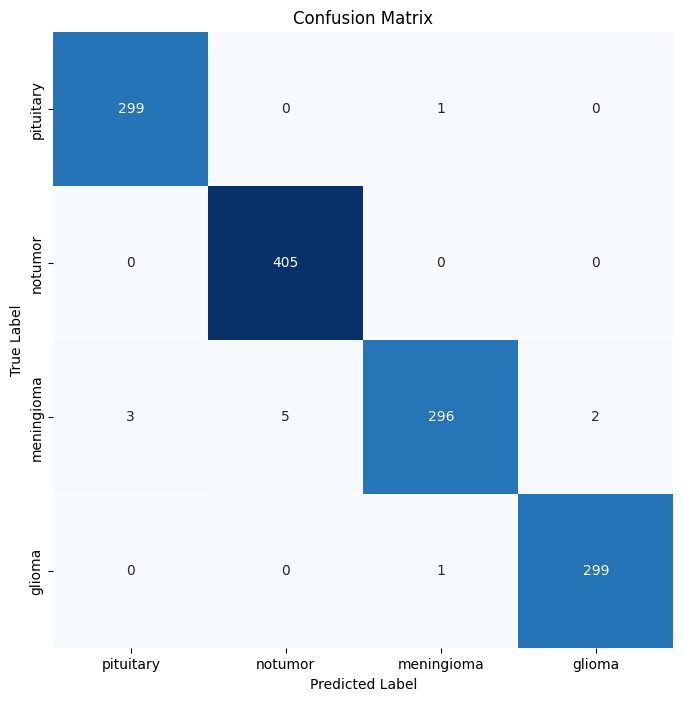

Class-wise metrics:
Class: pituitary
Precision: 0.9901
Recall: 0.9967
F1-Score: 0.9934

Class: notumor
Precision: 0.9878
Recall: 1.0000
F1-Score: 0.9939

Class: meningioma
Precision: 0.9933
Recall: 0.9673
F1-Score: 0.9801

Class: glioma
Precision: 0.9934
Recall: 0.9967
F1-Score: 0.9950

Overall Accuracy: 0.9908


In [18]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_naming,
                      metrics=True)

In [19]:
def plot_sample_predictions(model, dataset, indx_to_class, num_samples=9, figsize=(13, 12)):
    print('inside')
    plt.figure(figsize=figsize)
    rows = num_cols = int(np.sqrt(num_samples))
    print('rows', rows)

    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        print('inside the loop')
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        print(predictions)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = indx_to_class[true_class_index]
        predicted_class = indx_to_class[predicted_label]

        # Determine title color based on prediction accuracy
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


inside
rows 3
inside the loop
[[1.0000000e+00 7.1096536e-13 1.6981302e-11 1.9929660e-09]]
inside the loop
[[1.0000000e+00 3.0875272e-12 1.7488871e-10 1.4872388e-11]]
inside the loop
[[9.9999952e-01 2.8446809e-09 2.5939734e-12 4.8650350e-07]]
inside the loop
[[9.9993622e-01 4.9949257e-11 6.3829633e-05 2.6135284e-13]]
inside the loop
[[1.6072302e-01 4.6335248e-11 8.3927691e-01 1.1554003e-07]]
inside the loop
[[1.0000000e+00 5.3261288e-11 6.2309691e-09 1.2933974e-12]]
inside the loop
[[9.9999881e-01 1.9560495e-09 1.1657601e-06 1.8341910e-09]]
inside the loop
[[1.0000000e+00 1.2775410e-09 1.5644056e-15 2.5869380e-09]]
inside the loop
[[9.9999368e-01 7.6693582e-11 6.3646526e-06 1.8480522e-17]]


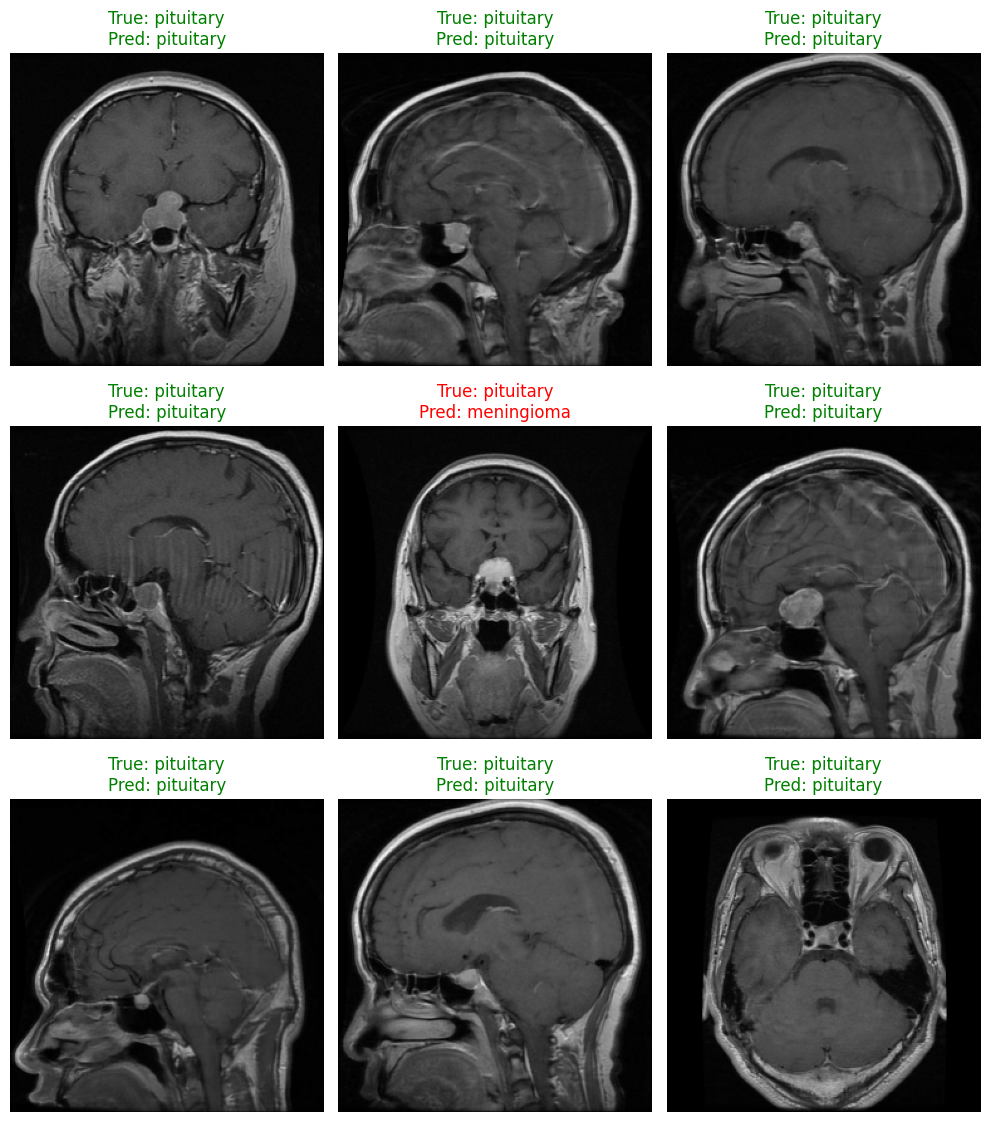

In [20]:
# Plottinng samples with predictions
plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed,
                        indx_to_class=inv_class_naming,
                        num_samples=9,
                        figsize=(10, 11.5))

In [25]:
def plot_misclassified_samples(model, dataset, indx_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())

        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(indx_to_class[true_class_index])
            misclassified_predictions.append(indx_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

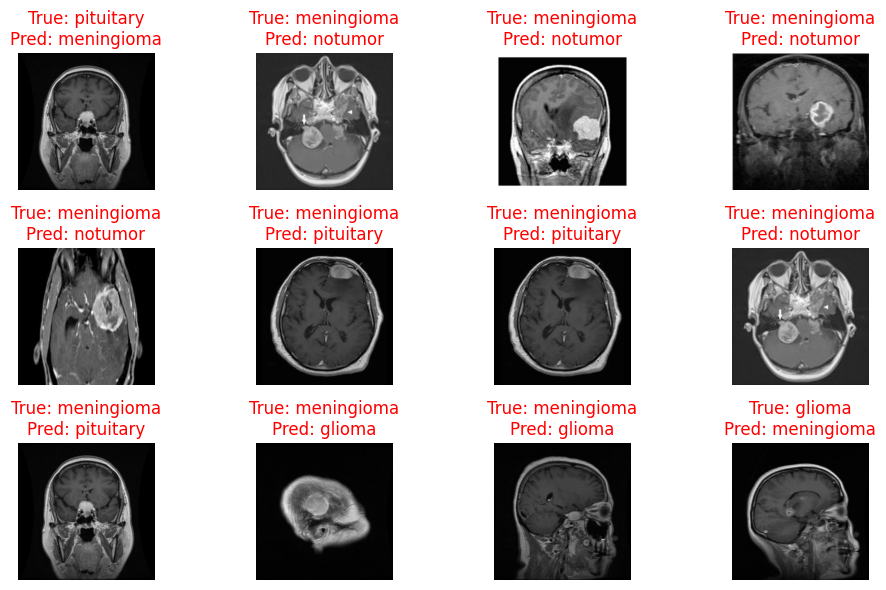

In [26]:
plot_misclassified_samples(model=model,
                           dataset=test_ds_preprocessed,
                           indx_to_class=inv_class_naming,
                           figsize=(10, 6))

In [27]:
def plot_confusion_matrix(true_labels, predicted_labels, class_naming, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_naming
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_naming.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_naming)):
            class_name = list(class_naming.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

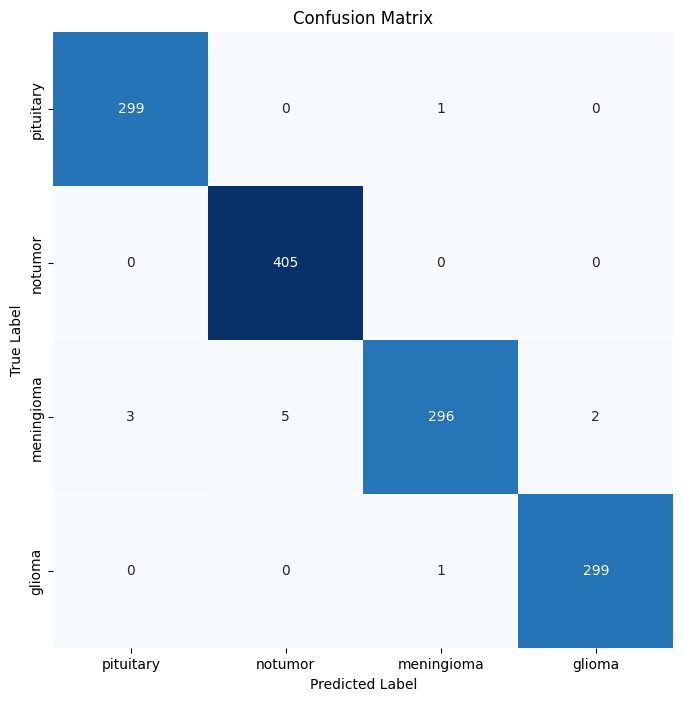

Class-wise metrics:
Class: pituitary
Precision: 0.9901
Recall: 0.9967
F1-Score: 0.9934

Class: notumor
Precision: 0.9878
Recall: 1.0000
F1-Score: 0.9939

Class: meningioma
Precision: 0.9933
Recall: 0.9673
F1-Score: 0.9801

Class: glioma
Precision: 0.9934
Recall: 0.9967
F1-Score: 0.9950

Overall Accuracy: 0.9908


In [28]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_naming,
                      metrics=True)

In [29]:
def plot_sample_predictions(model, dataset, indx_to_class, num_samples=9, figsize=(13, 12)):
    print('inside')
    plt.figure(figsize=figsize)
    rows = num_cols = int(np.sqrt(num_samples))
    print('rows', rows)

    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        print('inside the loop')
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        print(predictions)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = indx_to_class[true_class_index]
        predicted_class = indx_to_class[predicted_label]

        # Determine title color based on prediction accuracy
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

inside
rows 3
inside the loop
[[1.0000000e+00 7.1096536e-13 1.6981302e-11 1.9929660e-09]]
inside the loop
[[1.0000000e+00 3.0875272e-12 1.7488871e-10 1.4872388e-11]]
inside the loop
[[9.9999952e-01 2.8446809e-09 2.5939734e-12 4.8650350e-07]]
inside the loop
[[9.9993622e-01 4.9949257e-11 6.3829633e-05 2.6135284e-13]]
inside the loop
[[1.6072302e-01 4.6335248e-11 8.3927691e-01 1.1554003e-07]]
inside the loop
[[1.0000000e+00 5.3261288e-11 6.2309691e-09 1.2933974e-12]]
inside the loop
[[9.9999881e-01 1.9560495e-09 1.1657601e-06 1.8341910e-09]]
inside the loop
[[1.0000000e+00 1.2775410e-09 1.5644056e-15 2.5869380e-09]]
inside the loop
[[9.9999368e-01 7.6693582e-11 6.3646526e-06 1.8480522e-17]]


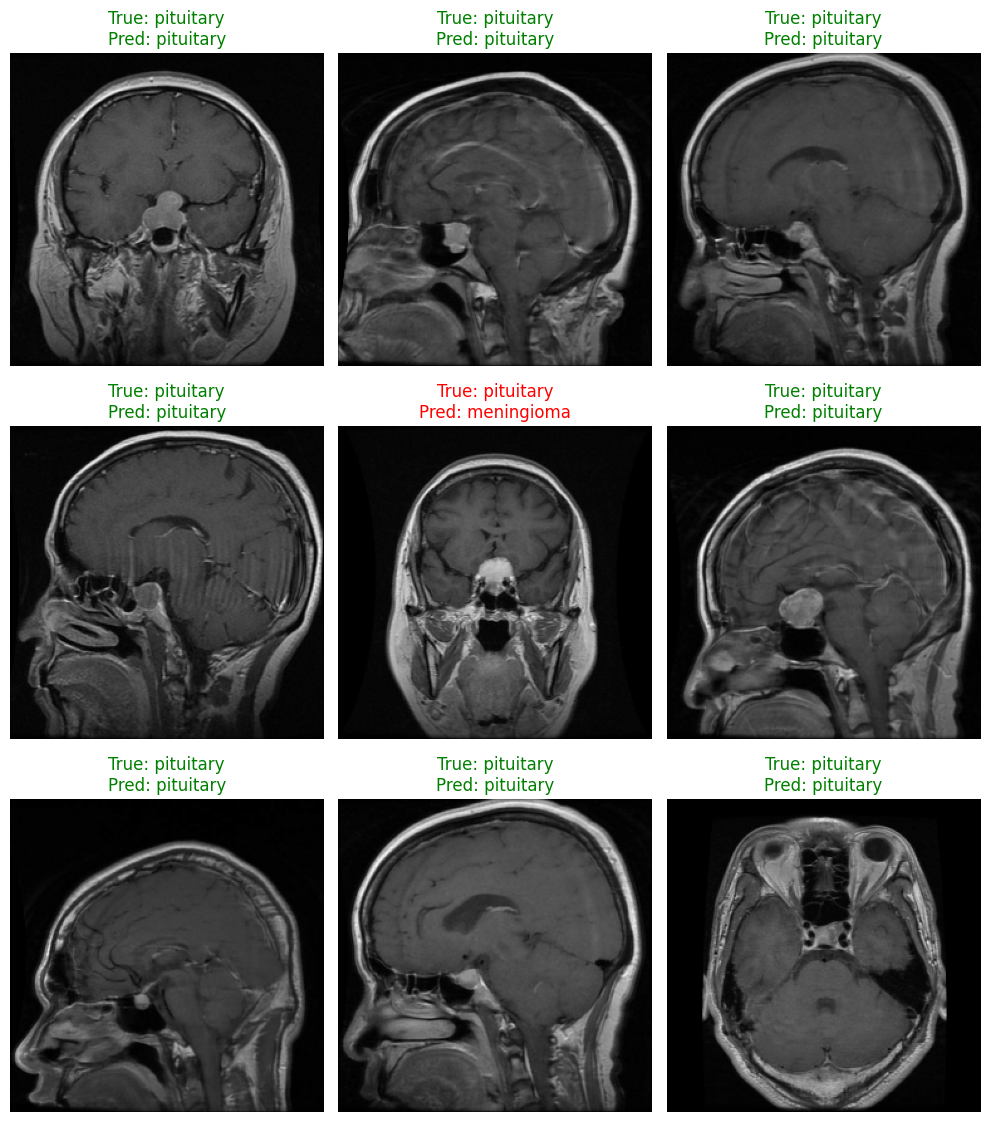

In [30]:
# Plottinng samples with predictions
plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed,
                        indx_to_class=inv_class_naming,
                        num_samples=9,
                        figsize=(10, 11.5))

In [31]:
def plot_misclassified_samples(model, dataset, indx_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())

        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(indx_to_class[true_class_index])
            misclassified_predictions.append(indx_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

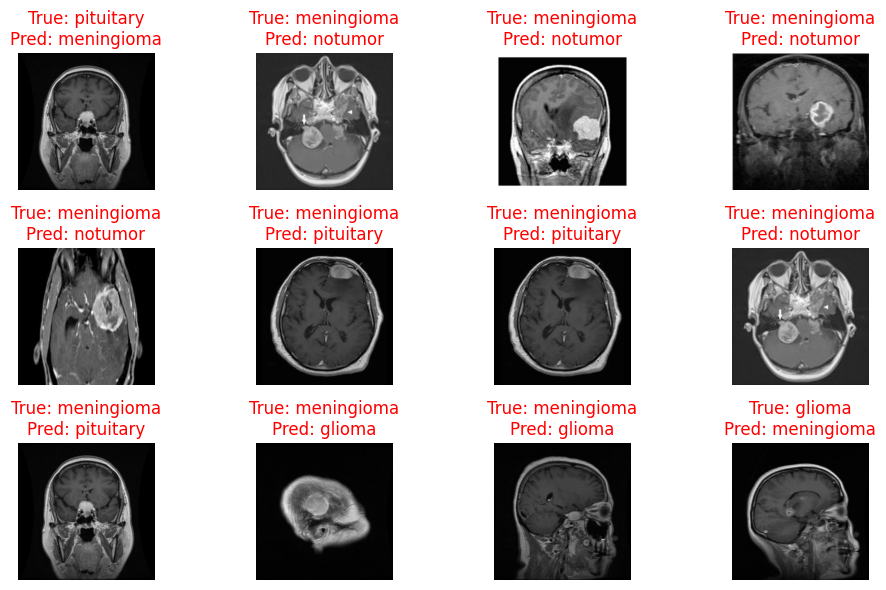

In [32]:
plot_misclassified_samples(model=model,
                           dataset=test_ds_preprocessed,
                           indx_to_class=inv_class_naming,
                           figsize=(10, 6))

In [40]:
# VGG16 Model Definition
def vgg16():
    base_model = VGG16(input_shape=(image_dim[0], image_dim[1], 3), include_top=False, weights='imagenet')
    # Set all layers to non-trainable
    for layer in base_model.layers:
        layer.trainable = False
    # Set the last vgg block to trainable
    base_model.layers[-2].trainable = True
    base_model.layers[-3].trainable = True
    base_model.layers[-4].trainable = True

    model = Sequential()
    model.add(Input(shape=(image_dim[0], image_dim[1], 3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(len(unique_names), activation='softmax'))
    return model

vgg16_model = vgg16()
# Compile VGG16 Model
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(vgg16_model.summary())
keras.utils.plot_model(vgg16_model, show_shapes=True)

# Train VGG16 Model
epochs = 5
batch_size = 20
steps = int(len(training_img_paths)/batch_size)
vgg16_model_hist = vgg16_model.fit(train_ds_preprocessed, epochs=epochs, validation_data=test_ds_preprocessed, steps_per_epoch=steps)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_4 (Dropout)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17926596 (68.38 MB)
Trainable params: 10

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/metrics/accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/metrics_utils.py", line 961, in sparse_categorical_matches
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 4 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](IteratorGetNext:1)' with input shapes: [?,4].


In [ ]:
# Plot learning curves for VGG16 Model
_, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
axes[0].plot(vgg16_model_hist.history['sparse_categorical_accuracy'], marker='o', linestyle='-', color='blue')
axes[0].plot(vgg16_model_hist.history['val_sparse_categorical_accuracy'], marker='o', linestyle='-', color='orange')
axes[0].set_title('VGG16 Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Validation'], loc='lower right')
axes[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
axes[1].plot(vgg16_model_hist.history['loss'], marker='o', linestyle='-', color='blue')
axes[1].plot(vgg16_model_hist.history['val_loss'], marker='o', linestyle='-', color='orange')
axes[1].set_title('VGG16 Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Validation'], loc='upper right')
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate VGG16 Model on the test set
test_loss_vgg16, test_accuracy_vgg16 = vgg16_model.evaluate(test_ds_preprocessed)
print(f"VGG16 Test accuracy: {test_accuracy_vgg16*100:.4f}%")

# Generate predictions for confusion matrix and metrics
true_labels_vgg16 = []
predicted_labels_vgg16 = []

for images, labels in test_ds_preprocessed.unbatch():
    true_label = np.argmax(labels.numpy())
    true_labels_vgg16.append(true_label)

    pred = vgg16_model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels_vgg16.append(predicted_label)

In [ ]:
# Plot confusion matrix for VGG16 Model
plot_confusion_matrix(true_labels_vgg16, predicted_labels_vgg16, class_naming, metrics=True)

In [ ]:
# Plot sample predictions for VGG16 Model
plot_sample_predictions(model=vgg16_model, dataset=test_ds_preprocessed, indx_to_class=inv_class_naming, num_samples=9, figsize=(10, 11.5))

In [ ]:
# Plot misclassified samples for VGG16 Model
plot_misclassified_samples(model=vgg16_model, dataset=test_ds_preprocessed, indx_to_class=inv_class_naming, figsize=(10, 6))